# Comparaison des classifieurs ensemblistes en utilisant le ré-échantillonnage

Les classifieurs ensemblistes ont montré qu'ils amélioraient les performances de classification par rapport à un seul modèle. Cependant, ils seront affectés par le déséquilibre des classes. Cet exemple montre les avantages d'équilibrer l'ensemble d'entraînement avant d'entraîner les modèles. Nous effectuons la comparaison avec des méthodes d'ensemble non équilibrées.

Nous effectuons une comparaison en utilisant l'exactitude équilibrée et la moyenne géométrique, qui sont des métriques largement utilisées dans la littérature pour évaluer les modèles entraînés sur un ensemble déséquilibré.

In [ ]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

In [1]:
print(__doc__)

Automatically created module for IPython interactive environment


## Charger un ensemble de données déséquilibré

Nous allons charger l'ensemble de données UCI SatImage, qui présente un ratio déséquilibré de 9,3 pour 1 (nombre d'échantillons de la classe majoritaire pour un échantillon de la classe minoritaire). Les données sont ensuite divisées en ensembles d'entraînement et de test.

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from imblearn.datasets import fetch_datasets

satimage = fetch_datasets()["satimage"]
X, y = satimage.data, satimage.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

## Classification à l'aide d'un arbre de décision unique

Nous entraînons un classifieur à base d'arbre de décision qui servira de base de référence pour le reste de cet exemple.

Les résultats sont rapportés en termes d'exactitude équilibrée et de moyenne géométrique, qui sont des métriques largement utilisées dans la littérature pour valider les modèles entraînés sur des ensembles de données déséquilibrés.

In [4]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

In [5]:
from sklearn.metrics import balanced_accuracy_score

from imblearn.metrics import geometric_mean_score

print("Decision tree classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_tree):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_tree):.2f}"
)

Decision tree classifier performance:
Balanced accuracy: 0.76 - Geometric mean 0.74


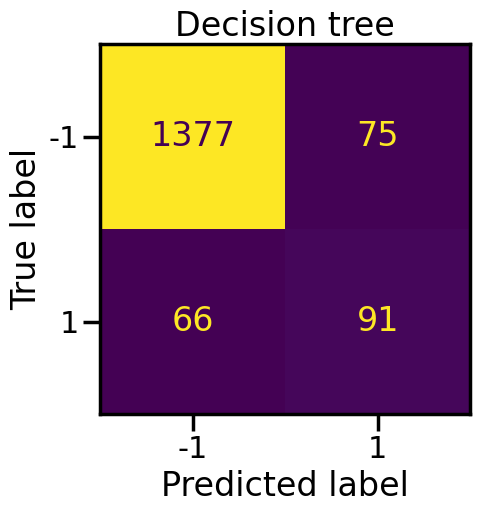

In [6]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

sns.set_context("poster")

disp = ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, colorbar=False)
_ = disp.ax_.set_title("Decision tree")

## Classification à l'aide d'un classifieur de type Bagging avec et sans échantillonnage

Au lieu d'utiliser un seul arbre, nous allons vérifier si un ensemble d'arbres de décision peut réellement atténuer le problème induit par le déséquilibre des classes. Tout d'abord, nous utiliserons un classifieur de type Bagging et son homologue qui utilise en interne un sous-échantillonnage aléatoire pour équilibrer chaque échantillon bootstrap.

In [7]:
from sklearn.ensemble import BaggingClassifier

from imblearn.ensemble import BalancedBaggingClassifier

bagging = BaggingClassifier(n_estimators=50, random_state=0)
balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=0)

bagging.fit(X_train, y_train)
balanced_bagging.fit(X_train, y_train)

y_pred_bc = bagging.predict(X_test)
y_pred_bbc = balanced_bagging.predict(X_test)

Équilibrer chaque échantillon bootstrap permet d'augmenter significativement l'exactitude équilibrée et la moyenne géométrique.

In [8]:
print("Bagging classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_bc):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_bc):.2f}"
)
print("Balanced Bagging classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_bbc):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_bbc):.2f}"
)

Bagging classifier performance:
Balanced accuracy: 0.73 - Geometric mean 0.68
Balanced Bagging classifier performance:
Balanced accuracy: 0.86 - Geometric mean 0.86


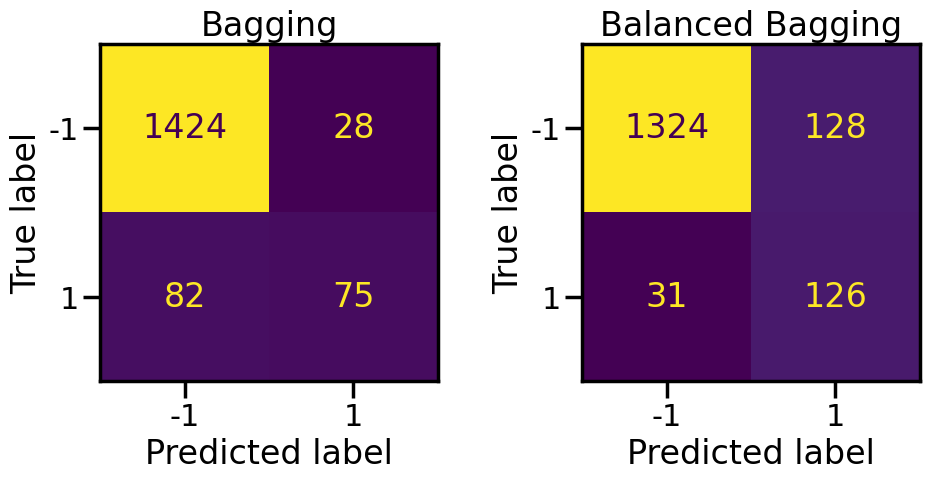

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
ConfusionMatrixDisplay.from_estimator(
    bagging, X_test, y_test, ax=axs[0], colorbar=False
)
axs[0].set_title("Bagging")

ConfusionMatrixDisplay.from_estimator(
    balanced_bagging, X_test, y_test, ax=axs[1], colorbar=False
)
axs[1].set_title("Balanced Bagging")

fig.tight_layout()

## Classification en utilisant le classifieur de forêt aléatoire avec et sans échantillonnage

La forêt aléatoire est une autre méthode d'ensemble populaire et elle dépasse généralement le bagging. Ici, nous avons utilisé une forêt aléatoire standard et son homologue équilibré dans lequel chaque échantillon bootstrap est équilibré.

In [10]:
from sklearn.ensemble import RandomForestClassifier

from imblearn.ensemble import BalancedRandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, random_state=0)
brf = BalancedRandomForestClassifier(
    n_estimators=50, sampling_strategy="all", replacement=True, random_state=0
)

rf.fit(X_train, y_train)
brf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_brf = brf.predict(X_test)

De manière similaire à l'expérience précédente, le classifieur équilibré surpasse le classifieur qui apprend à partir d'échantillons de bootstrap déséquilibrés. De plus, la forêt aléatoire surpasse le classifieur de bagging.

In [11]:
print("Random Forest classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_rf):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_rf):.2f}"
)
print("Balanced Random Forest classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_brf):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_brf):.2f}"
)

Random Forest classifier performance:
Balanced accuracy: 0.73 - Geometric mean 0.68
Balanced Random Forest classifier performance:
Balanced accuracy: 0.87 - Geometric mean 0.86


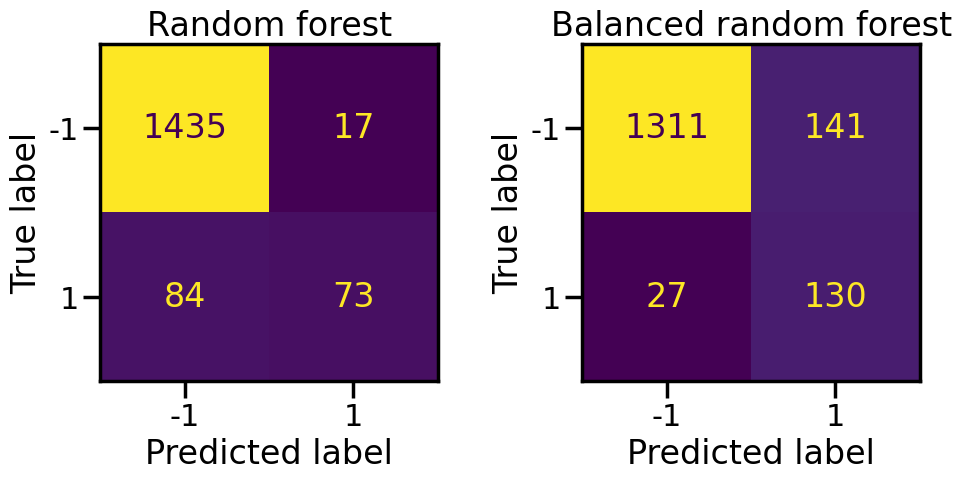

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, ax=axs[0], colorbar=False)
axs[0].set_title("Random forest")

ConfusionMatrixDisplay.from_estimator(brf, X_test, y_test, ax=axs[1], colorbar=False)
axs[1].set_title("Balanced random forest")

fig.tight_layout()

## Classifieur Boosting

De la même manière, le classifieur "easy ensemble" est un ensemble de classifieurs AdaBoost équilibrés. Cependant, il sera plus lent à s'entraîner que la forêt aléatoire et obtiendra de moins bonnes performances.

In [13]:
from sklearn.ensemble import AdaBoostClassifier

from imblearn.ensemble import EasyEnsembleClassifier, RUSBoostClassifier

estimator = AdaBoostClassifier(n_estimators=10)
eec = EasyEnsembleClassifier(n_estimators=10, estimator=estimator)
eec.fit(X_train, y_train)
y_pred_eec = eec.predict(X_test)

rusboost = RUSBoostClassifier(n_estimators=10, estimator=estimator)
rusboost.fit(X_train, y_train)
y_pred_rusboost = rusboost.predict(X_test)

In [14]:
print("Easy ensemble classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_eec):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_eec):.2f}"
)
print("RUSBoost classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_rusboost):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_rusboost):.2f}"
)

Easy ensemble classifier performance:
Balanced accuracy: 0.85 - Geometric mean 0.85
RUSBoost classifier performance:
Balanced accuracy: 0.85 - Geometric mean 0.85


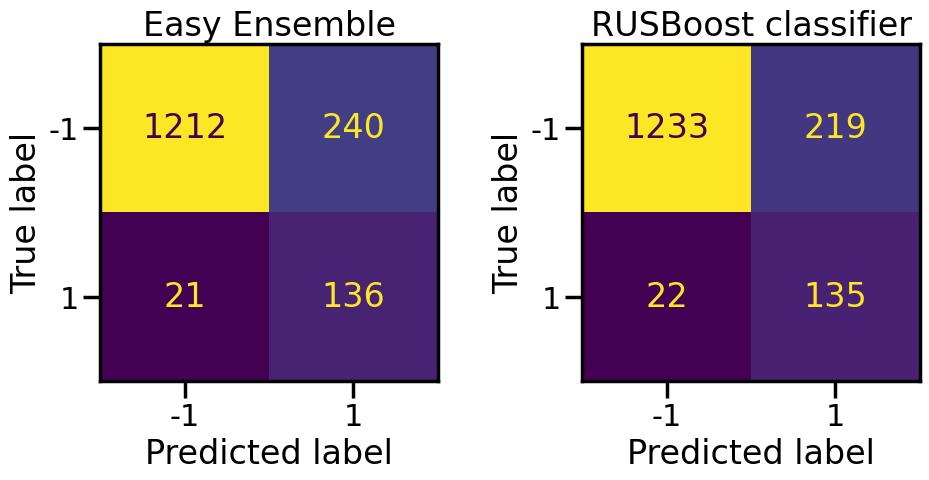

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

ConfusionMatrixDisplay.from_estimator(eec, X_test, y_test, ax=axs[0], colorbar=False)
axs[0].set_title("Easy Ensemble")
ConfusionMatrixDisplay.from_estimator(
    rusboost, X_test, y_test, ax=axs[1], colorbar=False
)
axs[1].set_title("RUSBoost classifier")

fig.tight_layout()
plt.show()